## Outline
Preprocess based on the paper linked in proposal. Their feature set consists of filtering the signal into the five main sub-bands. We then apply our feature extraction onto those individual subbands.
- Energy
- Entropy
- Hjorth parameters

In [1]:
import pickle
import numpy as np
from scipy.signal import welch as psd_welch
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from scipy.signal import butter as butter_filter
from scipy.signal import sosfilt
from scipy.signal import ricker   # for our wavelet transform

In [2]:
# Takes a minute or so
with open("./data/preprocessed/all_data.pkl", "rb") as fp:
    data = pickle.load(fp)

In [3]:
# assign slice for each epoch for our patient
# we need to create our concatentated arrays dynamically per patient
# this is because all of the data takes up 2GB with float32
# if we are splitting it into 6 subbands, that would take 12GB 
# doing it per patient is more memory efficient
patient_data_running_len = {}
patient_data_indices = {}
patient_data_x = {}
patient_data_y = {}
for pid, y, x_data in data:
    Ydata = patient_data_y.setdefault(pid, [])
    Xdata = patient_data_x.setdefault(pid, [])
    indices = patient_data_indices.setdefault(pid, [])
    # create index
    start_idx = patient_data_running_len.setdefault(pid, 0)
    end_idx = start_idx+len(x_data)
    index = slice(start_idx,end_idx)
    # add entries
    indices.append(index)
    Xdata.append(x_data)
    Ydata.append(y)
    # update our index
    patient_data_running_len[pid] = end_idx

In [12]:
Nfilter = 10
Fs = 100

band_filters_sos = [
    butter_filter(Nfilter, (0.5, 4), btype="bandpass", fs=Fs, output='sos'),
    butter_filter(Nfilter, (4,8),    btype="bandpass", fs=Fs, output='sos'),
    butter_filter(Nfilter, (8,12),   btype="bandpass", fs=Fs, output='sos'),
    butter_filter(Nfilter, (12,16),  btype="bandpass", fs=Fs, output='sos'),
    butter_filter(Nfilter, (16,30),  btype="bandpass", fs=Fs, output='sos'),
    butter_filter(Nfilter, (30,40),  btype="bandpass", fs=Fs, output='sos'),
]

wavelet_widths = np.arange(0, 10)
wavelet_fir_filters = [ricker(2**(i+3), 2**i) for i in wavelet_widths]

In [6]:
# energy features
def get_energy(x):
    return np.sum(np.abs(x))

# get power of our signal
def get_power(x):
    X = np.abs(x)**2
    N = x.shape[0]
    Y = (1/(2*N+1))*np.sum(X)
    return Y

In [7]:
# entropy features
def get_entropy(x):
    X = x**2
    X = X/np.sum(X)
    return np.sum(X*np.log2(X)) 

In [8]:
# hjorth features
def get_mobility(y):
    dy_dt = np.gradient(y)
    return (np.var(dy_dt)/np.var(y))**0.5

def get_hjorth_features(x):
    dx_dt = np.gradient(x)
    x_activity = np.var(x)
    x_mobility = get_mobility(x)
    x_complexity = get_mobility(dx_dt)/x_mobility
    return (x_activity, x_mobility, x_complexity)

In [9]:
# we have 6 subbands
# x_subbands.shape = (6, N)
# y_data.shape = (K,)
# indices.shape = (K,)
# K*len(epoch) = N
# divide our subbands into per epoch
def generate_subband_epochs(x_subbands, y_data, indices):
    for idx, y in zip(indices, y_data):
        x_epoch_subbands = x_subbands[:,idx]
        yield (x_epoch_subbands, y)

# for each epoch in our subbands, get our features
# power, entropy, hjorth, std
# and their relative counterparts
# each of these measurements are of shape (Nsubbandsx1) 
# except hjorth, that is (Nsubbands,3), where it is the 3 hjorth measurements
# where Nsubbands = 6
def extract_features_from_subbands(x_subbands, y_data, indices):
    # go through each epoch and extract features
    # generate our per epoch features
    for x_epoch_subbands, y in generate_subband_epochs(x_subbands, y_data, indices):
        energy = np.array([get_energy(x) for x in x_epoch_subbands])
        power = np.array([get_power(x) for x in x_epoch_subbands])
        entropy = np.array([get_entropy(x) for x in x_epoch_subbands])
        hjorth = np.array([np.array(get_hjorth_features(x)) for x in x_epoch_subbands])
        std = np.std(x_epoch_subbands, axis=1)
        # calculate relative values of features within the epoch
        rel_energy = energy/np.sum(energy)
        rel_power = power/np.sum(power)
        rel_entropy = entropy/np.sum(entropy)
        rel_hjorth = hjorth/np.sum(hjorth, axis=0)
        rel_std = std/np.sum(std)
        # return our features
        features = (
            energy, power, entropy, hjorth, std,
            rel_energy, rel_power, rel_entropy, rel_hjorth, rel_std)
        #features = (energy, entropy, std)
        yield (features, y)

In [11]:
# allocate our numpy arrays to store the time domain data for each patient
# then filter them into subbands and divide into epochs
# for each epoch we do our preprocessing
subband_data = []

pids = list(patient_data_x.keys())
for pid in tqdm(pids):
    x_data_refs = patient_data_x[pid]
    y_data = patient_data_y[pid]
    idxs = patient_data_indices[pid]
    
    # allocate our contiguous array for subband filtering
    Ndata = sum((len(x) for x in x_data_refs))
    x_data = np.zeros((Ndata,), dtype=np.float32)
    for idx, x_data_ref in zip(idxs, x_data_refs):
        x_data[idx] = x_data_ref
    #print(f"pid={pid}, sizeof(x_data)={Ndata*4*1e-6}MB")
    
    # normalise per patient
    # a, b = np.min(x_data), np.max(x_data)
    # x_data = (x_data-a) * (1/(b-a))
    x_data = x_data* 1e-6; # convert back to uV
    
    # filter into our subbands
    x_subband_data = []
    for band_filter_sos in band_filters_sos:
        x_subband = sosfilt(band_filter_sos, x_data)
        x_subband_data.append(x_subband)
    
    for wavelet_filter in wavelet_fir_filters:
        x_subband = np.convolve(x_data, wavelet_filter, mode='same')
        x_subband_data.append(x_subband)
        
    x_subband_data = np.array(x_subband_data)
    
    # for each subband get our features
    for features, y in extract_features_from_subbands(x_subband_data, y_data, idxs):
        feature_vec = [f.flatten() for f in features]
        feature_vec = np.concatenate(feature_vec).flatten()
        subband_data.append((pid, *feature_vec, y))

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [20:03<00:00, 15.63s/it]


In [16]:
with open("./data/preprocessed/subband_data.pkl", "wb+") as fp:
    pickle.dump(subband_data, fp)

In [15]:
feature_names = ["energy", "power", "entropy", "activity", "mobility", "complexity", "std"]
#feature_names = ["energy", "entropy", "std"]
subband_names = \
    ["delta", "theta", "alpha", "sigma", "beta", "gamma"] +\
    [f"ricker_{i}" for i in wavelet_widths]

columns = []

for feature_name in feature_names:
    for subband_name in subband_names:
        columns.append(f"{feature_name}_{subband_name}")

rel_columns = [f"{col}_rel" for col in columns]
columns.extend(rel_columns)
columns = ["pid", *columns, "sleep_stage"]

df = pd.DataFrame(subband_data, columns=columns)
df = df.dropna()
df.to_csv("./data/preprocessed/subband_data.csv", index=False)

In [40]:
df.head()

,pid,energy_delta,energy_theta,energy_alpha,energy_sigma,energy_beta,energy_gamma,power_delta,power_theta,power_alpha,...,complexity_sigma_rel,complexity_beta_rel,complexity_gamma_rel,std_delta_rel,std_theta_rel,std_alpha_rel,std_sigma_rel,std_beta_rel,std_gamma_rel,sleep_stage
0,0,6.458422e-08,3.348426e-08,1.821263e-08,1.452232e-08,2.862743e-08,2.192340e-08,1.085956e-22,2.570586e-23,7.212566e-24,...,0.061143,0.222987,0.159795,0.373990,0.181958,0.096383,0.077582,0.152697,0.117390,0
1,0,5.939413e-08,3.227698e-08,1.600411e-08,1.399455e-08,2.682881e-08,2.315599e-08,8.016377e-23,2.429220e-23,5.652740e-24,...,0.082344,0.224591,0.158122,0.347911,0.191519,0.092386,0.081487,0.153884,0.132813,0
2,0,8.453926e-08,3.775873e-08,2.116094e-08,1.748458e-08,3.263332e-08,2.699327e-08,1.741261e-22,3.332058e-23,1.082900e-23,...,0.064671,0.225583,0.158682,0.385681,0.168715,0.096181,0.077409,0.150094,0.121920,0
3,0,7.313939e-08,3.467438e-08,1.777651e-08,1.309878e-08,2.407336e-08,1.956210e-08,1.367521e-22,2.916225e-23,7.184310e-24,...,0.049023,0.222046,0.158709,0.408347,0.188570,0.093595,0.068454,0.131433,0.109602,0
4,0,5.658799e-08,2.814243e-08,1.388601e-08,1.036544e-08,1.785905e-08,1.418988e-08,8.828267e-23,1.990021e-23,4.400411e-24,...,0.040670,0.224698,0.157972,0.416541,0.197764,0.092997,0.070338,0.121295,0.101064,0


In [18]:
np.unique(df['pid']).shape

(77,)

In [20]:
pid = 1
idx = (df["pid"] == pid)
patient_df = df[idx]

data = patient_df.to_numpy()
y = data[:,-1]
X = data[:,1:-1]

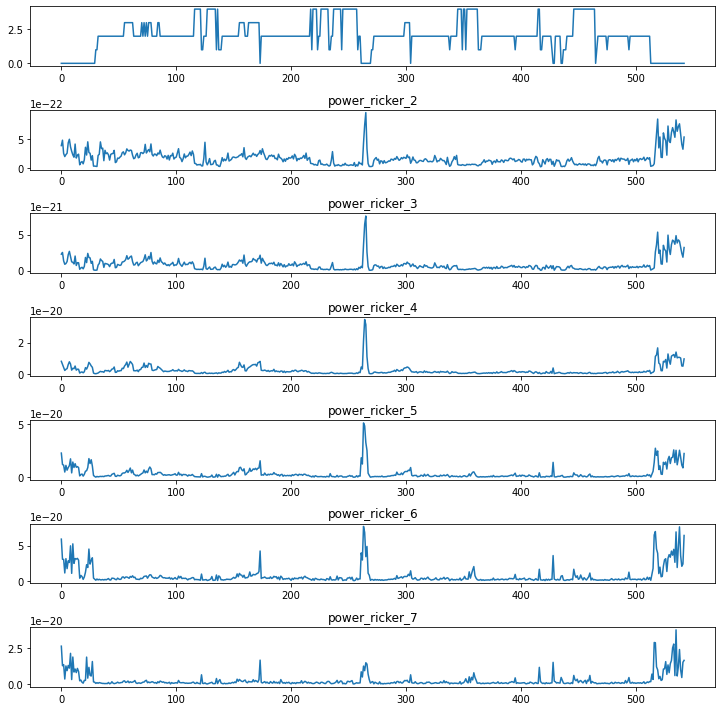

In [21]:
#idx = np.arange(0,6)
#idx = np.arange(6,12)
#idx = np.arange(12,18)
#idx = np.arange(18,24)
idx = np.arange(24,30)

Xd = X[:,idx]
Nfeatures = Xd.shape[1]
fig, axs = plt.subplots(Nfeatures+1, 1, figsize=(10,10))
axs[0].plot(y)

for i in range(Nfeatures):
    ax = axs[i+1]
    ax.plot(Xd[:,i])
    ax.set_title(columns[idx[i]+1])

plt.tight_layout()